# Fit mrCOSTS to the LIDAR data (all velocity components)

In [1]:
# netcdf/numpy/xray/stats
import numpy as np
import xarray as xr
import pandas as pd
import copy
import scipy
from scipy import signal
import glob
from pydmd.costs import COSTS
from pydmd.mrcosts import mrCOSTS

# OS interaction
import os
import sys

# import plotting
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.dates import DateFormatter
from matplotlib.colors import ListedColormap

# PyDMD can generate way too many warnings
import warnings

warnings.filterwarnings("ignore")

## Format plots

In [2]:
%matplotlib inline
# Higher resolution figures within the notebook
%config InlineBackend.figure_format = 'retina'

# Set the plot style from the seaborn library
sns.set_style("whitegrid")
context = "paper"
sns.set_context(context)

# Tol bright color scheme reordered to put my favorite colors first
tol_bright_reorder = [
    "#4477AA",
    "#CCBB44",
    "#EE6677",
    "#228833",
    "#66CCEE",
    "#AA3377",
    "#BBBBBB",
]
sns.set_palette(sns.color_palette(tol_bright_reorder))


# Data

In [3]:
dir_notebook = os.getcwd()
dir_data = os.path.join(dir_notebook, "data")
dir_print = os.path.join(dir_notebook, "figures/SI figures")
dir_results = os.path.join(dir_notebook, "mrCOSTS fit")

In [11]:
components = ["w", "u", "v"]
domain_list = ["1km", "500m", "250m", "125m", "lidar"]
domain_titles_dict = {
    "1km": "DX1000",
    "500m": "DX500",
    "250m": "DX250",
    "125m": "DX1215",
    "lidar": "lidar",
}

os.chdir(dir_data)
domain = "lidar"
ds_obs = xr.open_dataset(f"{domain}.publication-version.nc").load()

ts = ds_obs.time
ts = ts - ts.isel(time=0)
ts = (ts / 1e9).values.astype(float)
# Time step in seconds
dt = 80

# Stack the three components
data = np.concatenate((ds_obs["w"].T.values, ds_obs["u"].T.values, ds_obs["v"].T.values))

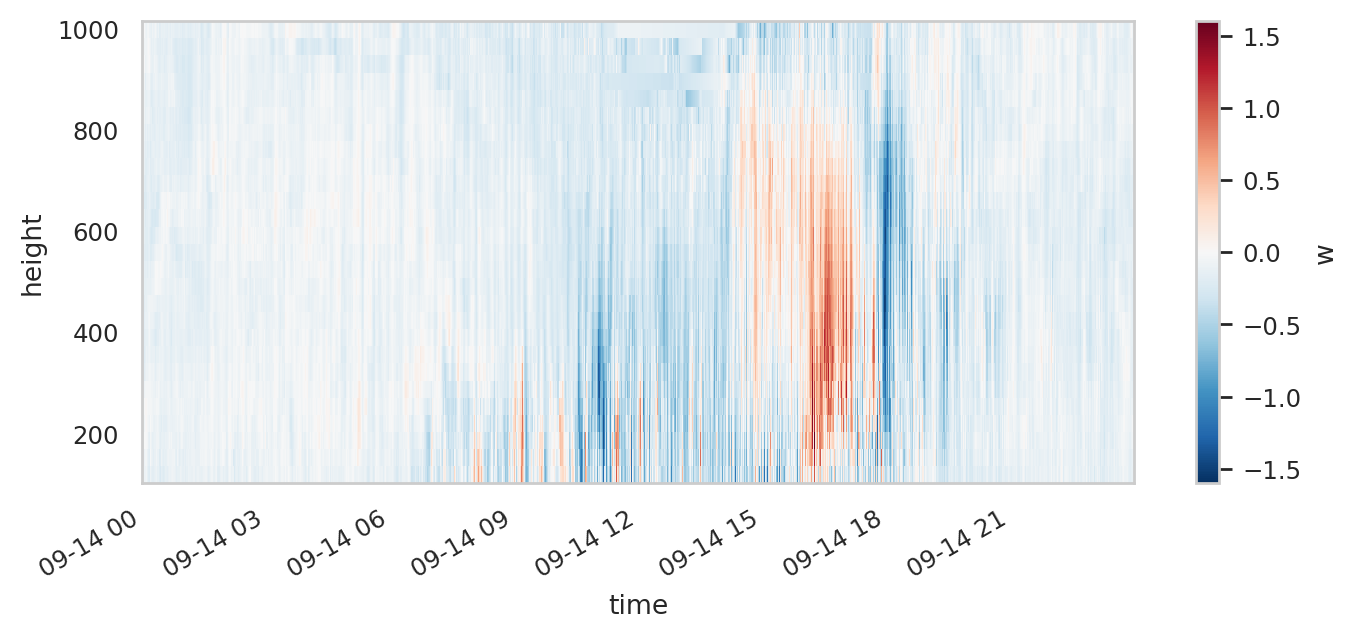

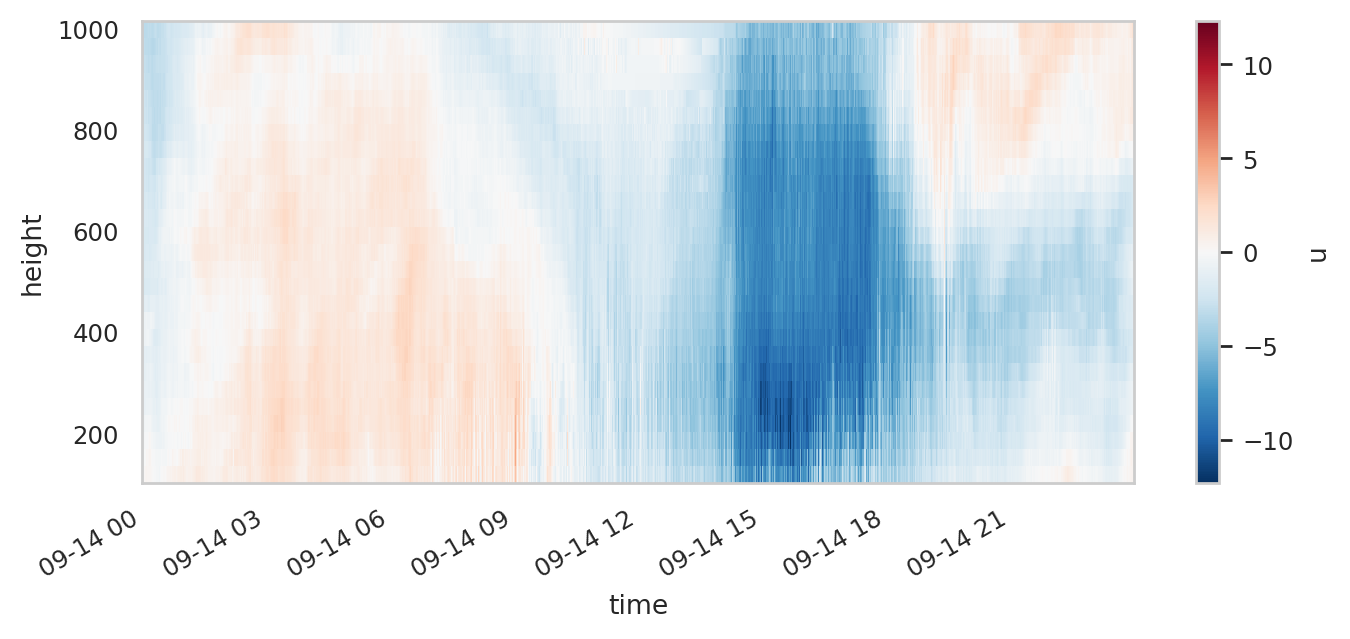

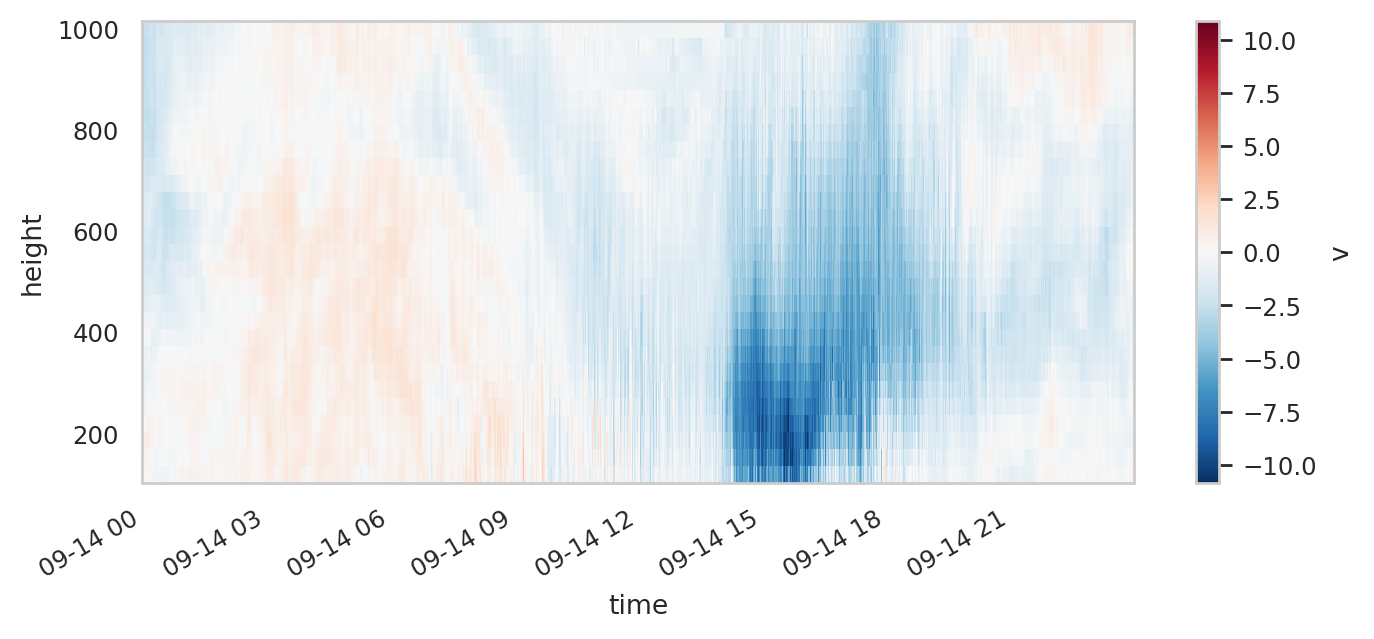

In [12]:
for comp in ["w", "u", "v"]:
    fig, ax = plt.subplots(1, 1, figsize=(8, 3))
    ds_obs[comp].T.plot(ax=ax)

# Fit mrCOSTS

The `limited` and `conjugate_pairs` kwargs require a version of mrCOSTS newer than March 2025.

In [18]:
ds = xr.open_dataset("/home/karl/Dropbox/ESPRIT/proj/data/costs-results/CROSSINN/vertical-velocity-comparison/v2025-01-17/lidar.conj-pairs.window=15.nc")
ds.

<xarray.Dataset>
Dimensions:            (window_time_means: 534, svd_rank: 10, space: 81,
                        frequency_band: 5, window_index: 15)
Coordinates:
  * window_time_means  (window_time_means) float64 560.0 720.0 ... 8.576e+04
    slide              (window_time_means) int64 ...
  * svd_rank           (svd_rank) int64 0 1 2 3 4 5 6 7 8 9
  * space              (space) int64 0 1 2 3 4 5 6 7 ... 73 74 75 76 77 78 79 80
  * frequency_band     (frequency_band) int64 0 1 2 3 4
  * window_index       (window_index) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14
    time               (window_time_means, window_index) float64 ...
Data variables:
    omega              (window_time_means, svd_rank) {'names': ['r', 'i'], 'formats': ['<f8', '<f8'], 'offsets': [0, 8], 'itemsize': 16, 'aligned': True} ...
    omega_classes      (window_time_means, svd_rank) int64 ...
    amplitudes         (window_time_means, svd_rank) {'names': ['r', 'i'], 'formats': ['<f8', '<f8'], 'offsets': [0, 8], 'itemsize': 16, 'aligned': True} ...
    modes              (window_time_means, space, svd_rank) {'names': ['r', 'i'], 'formats': ['<f8', '<f8'], 'offsets': [0, 8], 'itemsize': 16, 'aligned': True} ...
    window_means       (window_time_means, space) float64 ...
    cluster_centroids  (frequency_band) float64 ...
Attributes: (12/15)
    svd_rank:                       10
    svd_rank_pre_allocate:          10
    omega_transformation:           absolute
    n_slides:                       534
    window_length:                  15
    num_frequency_bands:            5
    ...                             ...
    relative_filter_length:         4
    kern_method:                    flat
    pydmd_kwargs__eig_constraints:  ['limited', 'conjugate_pairs']
    pydmd_kwargs__real_eig_limit:   0.01
    pydmd_kwargs__eig_sort:         imag
    pydmd_kwargs__proj_basis:       None

In [19]:
# Window size (in time steps)
window_lengths = np.array([8, 15, 30, 60, 120, 240, 480, 650])
step_sizes = np.array([2, 2, 3, 6, 12, 24, 48, 65])
svd_ranks = [6, 10, 10, 10, 10, 10, 10, 10]
num_decompositions = len(window_lengths)
global_svd_array = [False] * len(window_lengths)
pydmd_kwargs = {
    "eig_constraints": {"conjugate_pairs", "limited"},
    "real_eig_limit": 0.01,
}
strategy = "conj-pairs"
data_name = "lidar"
relative_filter_length = 4
kern_method = "flat"
num_frequency_bands = np.array(svd_ranks) // 2

# Set this flag to `True` in order to execute the fits
fit = True

In [14]:
if fit:
    mrc = mrCOSTS(
        svd_rank_array=svd_ranks,
        window_length_array=window_lengths,
        step_size_array=step_sizes,
        global_svd_array=global_svd_array,
        transform_method="absolute",
        pydmd_kwargs=pydmd_kwargs,
        n_components_array=num_frequency_bands,
        kern_method="flat",
        relative_filter_length=relative_filter_length,
    )

    mrc.fit(data, np.atleast_2d(ts))

_________________________________________________
Fitting window length = 8
0 of 537
50 of 537
100 of 537
150 of 537
200 of 537
250 of 537
300 of 537
350 of 537
400 of 537
450 of 537
500 of 537
Error in Global Reconstruction = 0.025
_________________________________________________
Fitting window length = 15
0 of 534
50 of 534
100 of 534
150 of 534
200 of 534
250 of 534
300 of 534
350 of 534
400 of 534
450 of 534
500 of 534
Error in Global Reconstruction = 0.0028
_________________________________________________
Fitting window length = 30
0 of 351
50 of 351
100 of 351
150 of 351
200 of 351
250 of 351
300 of 351
350 of 351
Error in Global Reconstruction = 0.0033
_________________________________________________
Fitting window length = 60
0 of 171
50 of 171
100 of 171
150 of 171
Error in Global Reconstruction = 0.0007
_________________________________________________
Fitting window length = 120
0 of 81
50 of 81
Error in Global Reconstruction = 0.00077
____________________________________

In [20]:
os.chdir(dir_results)
filename = ".".join([data_name, strategy])

if fit:
    file_list = glob.glob("*" + filename + "*.nc")
    map(os.remove, file_list)
    mrc.to_netcdf(filename)

else:
    file_list = glob.glob("*" + filename + "*.nc")
    mrc = mrCOSTS()
    mrc.from_netcdf(file_list)

# Initial evaluation of the fits

Use these plots to get a sense of how the mrCOSTS hyperparameters performed.

In [21]:
local_scale_separation_plots = False

if local_scale_separation_plots:

    # Plot all decomposition levels
    for n_decomp in range(0, num_decompositions):
        mrd = mrc.costs_array[n_decomp]

        # The data for each decomposition level is built here to avoid
        # reconstructing the data for each plot. If this is not done the
        # plots can still be rendered but will take slightly longer.
        if n_decomp == 0:
            x_iter = data
        else:
            x_iter, _ = mrc.costs_array[n_decomp - 1].scale_separation(
                scale_reconstruction_kwargs=mrc._costs_recon_kwargs
            )

        for ncomp, comp in enumerate(components):
            # Single points in space
            space_index = 5 + len(ds_obs["height"]) * ncomp
            _, _ = mrc.plot_local_time_series(
                space_index,
                n_decomp,
                x_iter,
                scale_reconstruction_kwargs=mrc._costs_recon_kwargs,
            )

In [22]:
local_scale_separation_plots = False

if local_scale_separation_plots:

    # Plot all decomposition levels
    for n_decomp in range(0, num_decompositions):
        mrd = mrc.costs_array[n_decomp]

        # The data for each decomposition level is built here to avoid
        # reconstructing the data for each plot. If this is not done the
        # plots can still be rendered but will take slightly longer.
        if n_decomp == 0:
            x_iter = data
        else:
            x_iter, _ = mrc.costs_array[n_decomp - 1].scale_separation(
                scale_reconstruction_kwargs=mrc._costs_recon_kwargs
            )
        mrc.plot_local_scale_separation(n_decomp, data=x_iter)

        mrc.plot_local_error(
            n_decomp, data=x_iter, plot_kwargs={"vmin": -10, "vmax": 10}
        )

        fig1, ax1 = mrd.plot_omega_histogram()
        fig1.suptitle("Window length={}".format(mrd.window_length))

# Global scale separation

fitting n_components = 8
fitting n_components = 9
fitting n_components = 10
fitting n_components = 11
fitting n_components = 12
fitting n_components = 13
fitting n_components = 14
fitting n_components = 15
fitting n_components = 16
fitting n_components = 17
fitting n_components = 18
fitting n_components = 19
fitting n_components = 20
fitting n_components = 21
fitting n_components = 22
fitting n_components = 23
Optimal silhouette score is = 18


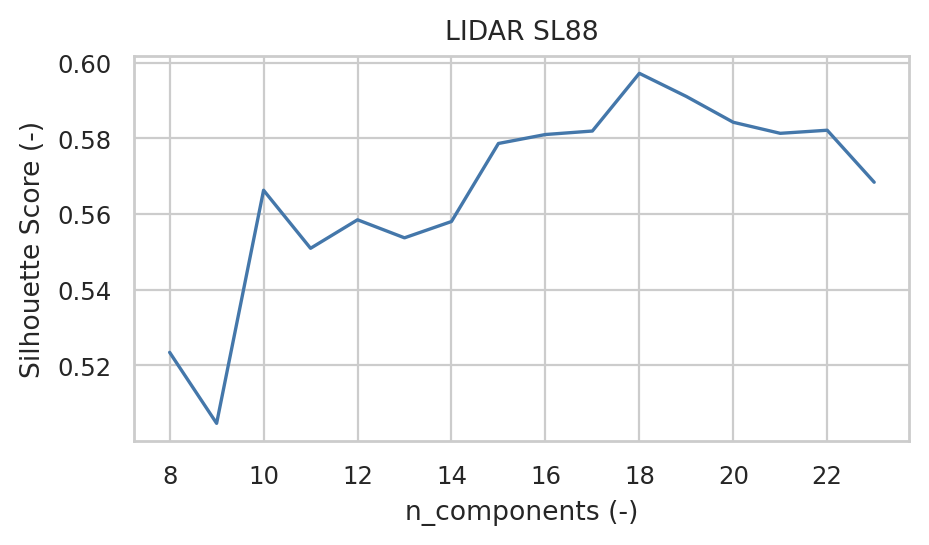

In [23]:
score = True
if score:

    n_components_range = np.arange(8, 24)
    scores, n_optimal = mrc.global_cluster_hyperparameter_sweep(
        n_components_range, transform_method="log10"
    )

    print("Optimal silhouette score is = {}".format(n_optimal))
    plt.figure(figsize=(5, 2.5))
    plt.plot(n_components_range, scores)
    plt.gca().set_xlabel("n_components (-)")
    plt.gca().set_title("LIDAR SL88")
    plt.gca().set_ylabel("Silhouette Score (-)")

else:
    n_optimal = 18

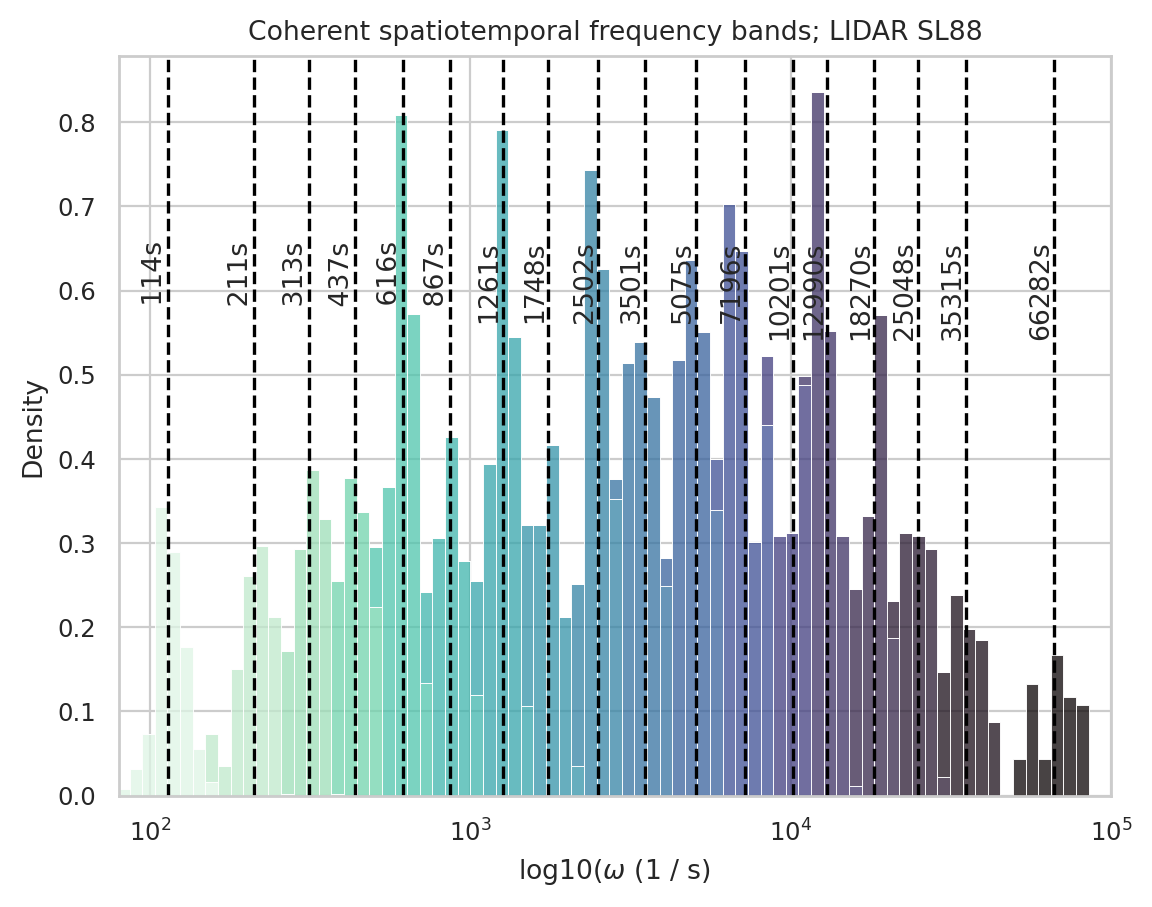

In [27]:
cluster_centroids, omega_classes, omega_array = mrc.global_cluster_omega(
    n_optimal, transform_method="log10"
)

hue_order = np.arange(len(np.unique(omega_classes))).astype(str)

sns.histplot(
    x=(2 * np.pi) / (10**omega_array),
    hue=omega_classes,
    hue_order=hue_order,
    common_bins=True,
    common_norm=True,
    stat="density",
    multiple="stack",
    bins=100,
    palette="mako",
    legend=False,
    log_scale=True,
)

ax = plt.gca()
ax.set_title("Coherent spatiotemporal frequency bands; LIDAR SL88")
ax.set_xlabel(r"log10($\omega$ (1 / s)")
[
    ax.axvline((2 * np.pi) / (10**c), color="k", ls="--")
    for nc, c in enumerate(cluster_centroids)
]

ylim_bottom, ylim_top = ax.get_ylim()
[
    ax.text(
        (2 * np.pi) / 10**c,
        ylim_top - (ylim_top - ylim_bottom) / 4,
        "{:4.0f}s".format((2 * np.pi) / (10 ** (c))),
        rotation="vertical",
        va="top",
        ha="right",
    )
    for c in cluster_centroids
]
ax.set_xlim(80, 10**5);

# Error

You should evaluate mrCOSTS hyperparameters using an objective function like the error of the fit.

In [28]:
xr_sep = mrc.global_scale_reconstruction()
xr_background = mrc.get_background()
xr_global = xr_sep.sum(axis=(0, 1)) + xr_background
error = mrc.costs_array[0].relative_error(xr_global, data)
print(f"mrCOSTS error = {error:.2f}")

mrCOSTS error = 0.03
